<a href="https://colab.research.google.com/github/QingfangLiu/ml-dl-notebooks/blob/main/DDI_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my implementation of the GNN GraghSage model on the OGB DDI dataset

In [ ]:
# check pytorch version and its cuda support
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
%%bash
TORCH_VER=2.6.0
CUDA_VER=cu124

# Install dependencies
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH_VER}+${CUDA_VER}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH_VER}+${CUDA_VER}.html
pip install torch-geometric
pip install ogb

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0

In [ ]:
# imports
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

2.6.0+cu124
2.6.1


In [ ]:
# imports
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from tqdm import trange # use progress bar

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# load ogbl-ddi dataset
from ogb.linkproppred import PygLinkPropPredDataset
import torch
import functools

# Temporarily patch torch.load to set weights_only=False
original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_torch_load(*args, **kwargs)

torch.load = patched_torch_load

try:
    dataset = PygLinkPropPredDataset(name='ogbl-ddi')
finally:
    # Restore the original torch.load function
    torch.load = original_torch_load

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:02<00:00, 16.62it/s]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2555.94it/s]

Saving...



Done!


In [ ]:
# This graph only contains training edges but no node features

ddi_graph = dataset[0]

print(f'DDI graph object: {ddi_graph}')
print(f'Number of nodes |V|: {ddi_graph.num_nodes}')
print(f'Number of (training) edges |E|: {ddi_graph.num_edges}')
print(f'Is undirected: {ddi_graph.is_undirected()}')
# Note that since the graph is undirected, PyG includes both (u, v) and (v, u) as edges
print(f'Average node degree: {ddi_graph.num_edges / ddi_graph.num_nodes:.2f}')
print(f'Number of node features: {ddi_graph.num_node_features}')
print(f'Has isolated nodes: {ddi_graph.has_isolated_nodes()}')
print(f'Has self-loops: {ddi_graph.has_self_loops()}')

DDI graph object: Data(num_nodes=4267, edge_index=[2, 2135822])
Number of nodes |V|: 4267
Number of (training) edges |E|: 2135822
Is undirected: True
Average node degree: 500.54
Number of node features: 0
Has isolated nodes: False
Has self-loops: False


In [ ]:
# dataset split using protein-target split
# Temporarily patch torch.load to set weights_only=False for get_edge_split as well
original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_torch_load(*args, **kwargs)

torch.load = patched_torch_load

try:
    split_edge = dataset.get_edge_split()
finally:
    # Restore the original torch.load function
    torch.load = original_torch_load

train_edges = split_edge['train']
valid_edges = split_edge['valid']
test_edges = split_edge['test']

In [ ]:
print(f'Number of training positive edges: {train_edges["edge"].shape[0]}')
print(f'Number of validation positive edges: {valid_edges["edge"].shape[0]}')
print(f'Number of validation negative edges: {valid_edges["edge_neg"].shape[0]}')
print(f'Number of test positive edges: {test_edges["edge"].shape[0]}')
print(f'Number of test negative edges: {valid_edges["edge_neg"].shape[0]}')

Number of training positive edges: 1067911
Number of validation positive edges: 133489
Number of validation negative edges: 101882
Number of test positive edges: 133489
Number of test negative edges: 101882


In [ ]:
train_edges["edge"]

tensor([[4039, 2424],
        [4039,  225],
        [4039, 3901],
        ...,
        [ 647,  708],
        [ 708,  338],
        [ 835, 3554]])

In [ ]:
ddi_graph.num_edges//2 # the number of training edges matches exactly with half of edges in the whole graph
# in other words, ddi_graph is a subset of the full graph - the training-only
# subgraph; validation and test edges are held out entirely from this training graph

1067911

In [ ]:
# build graphsage class
class GraphSAGE(torch.nn.Module):
    def __init__(self, conv, in_channels, hidden_channels, out_channels, num_layers, dropout):
        # conv: a class or function to create a GraphSAGE layer (e.g. SAGEConv)
        # but note that SAGEConv does not accept edge features
        # it allows stacking multiple layers (2-3 is usually a good choice)
        super().__init__()
        self.convs = torch.nn.ModuleList() # initialize an ordered list of GNN layers
        assert (num_layers >= 2), "Number of layers must be at least 2" # one hidden layer corresponds to num_layers=2
        self.convs.append(conv(in_channels, hidden_channels, normalize=True)) # L2 normalization of output embeddings
        for _ in range(num_layers - 2): # optional: only useful when num_layers > 2, so having more than one hidden layer
            self.convs.append(conv(hidden_channels, hidden_channels, normalize=True))
        self.convs.append(conv(hidden_channels, out_channels, normalize=True))

        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr): # x is the matrix of initial node embeddings [N, in_channels]
        if edge_attr is not None: # if edge features are provided
            return self.forward_with_edge_attr(x, edge_index, edge_attr)

        # proceed with no edge features
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)  # message passing, recall self.convs is an ordered list of layers
            x = F.relu(x)                     # activation
            x = F.dropout(x, p=self.dropout, training=self.training) # dropout

        # generate embeddings
        x = self.convs[self.num_layers - 1](x, edge_index) # last layer (not relu or dropout)

        return x

    # if edge features are provided, note not all GNN layers accept edge features
    # GraghSAGE actually does not accept edge_attr
    def forward_with_edge_attr(self, x, edge_index, edge_attr):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # generate embeddings
        x = self.convs[self.num_layers - 1](x, edge_index, edge_attr)
        return x

In [ ]:
# set up some parameters
graphsage_in_channels = 256
graphsage_hidden_channels = 256
graphsage_out_channels = 256
graphsage_num_layers = 2
dropout = 0.5

In [ ]:
# create initial embeddings, learnable, updated during training
initial_node_embeddings = torch.nn.Embedding(ddi_graph.num_nodes, graphsage_in_channels).to(device)

In [ ]:
# prompt: to get dimension of initial_node_embeddings
print(f'Shape of initial node embeddings: {initial_node_embeddings.weight.shape}')
print(f'Dimension of initial node embeddings: {initial_node_embeddings.embedding_dim}')

Shape of initial node embeddings: torch.Size([4267, 256])
Dimension of initial node embeddings: 256


In [ ]:
# initializes the GraphSAGE model
graphsage_model = GraphSAGE(SAGEConv, graphsage_in_channels, graphsage_hidden_channels, graphsage_out_channels, graphsage_num_layers, dropout).to(device)

In [ ]:
# next build model for link prediction (from graghsage output embeddings)
link_predictor_in_channels = graphsage_out_channels # link predictor input channels comes from graphsage out channels
link_predictor_hidden_channels = link_predictor_in_channels # use the same for hidden channels

In [ ]:
# a small MLP that takes 2 node embeddings & predicts a scalar score
# this works on either a single edge, or a batch of edges
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout, out_channels=1, concat=lambda x, y:x * y): # element-wise multiplication
        super().__init__()
        self.model = nn.Sequential(nn.Linear(in_channels, hidden_channels),
                                   nn.ReLU(),
                                   nn.Dropout(p=dropout),
                                   nn.Linear(hidden_channels, out_channels),
                                   nn.Sigmoid())
        self.concat = concat

        # note: this is not a dot product that gives one number per edge
        # this allows MLP to learn the interaction between embedding dimensions

    def forward(self, u, v):
        x = self.concat(u, v) # output a full vector per edge (same dim as embedding)
        return self.model(x)

In [ ]:
link_predictor = LinkPredictor(in_channels=link_predictor_in_channels,
                               hidden_channels=link_predictor_hidden_channels,
                               dropout=dropout).to(device)

In [ ]:
# training
def train(graphsage_model, link_predictor, initial_node_embeddings, edge_index,
          pos_train_edges, optimizer, batch_size, edge_attr=None):

    # why we need both of them?
    # edge_index: input to GNN, defining the graph used for message passing (dim: 2*num_edges)
    # train_edges: targets for link prediction (dim: num_pos_train_edges*2)

    total_loss, total_examples = 0, 0

    # set models to train
    graphsage_model.train()
    link_predictor.train()

    # iterate over batches of training edges
    # each pos_samples will have shape of [batch_size, 2]
    for pos_samples in DataLoader(pos_train_edges, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad()

        # run GraphSAGE forward pass
        node_embeddings = graphsage_model(initial_node_embeddings, edge_index, edge_attr)

        # sample batch_size negative edges
        # find node pairs that are not connected in the graph (not in edge_index)
        # also note training negatives are generated on the fly
        # dim: [2, batch size]
        neg_samples = negative_sampling(edge_index,
                                        num_nodes=initial_node_embeddings.size(0),
                                        num_neg_samples=len(pos_samples),
                                        method='dense')

        # run link predictor forward pass on positive edge embeddings
        pos_preds = link_predictor(node_embeddings[pos_samples[:, 0]], node_embeddings[pos_samples[:, 1]])

        # run link predictor forward pass on negative edge embeddings
        # initially made a mistake here: note the dimension of the neg_samples is different from pos_samples
        #neg_preds = link_predictor(node_embeddings[neg_samples[:, 0]], node_embeddings[neg_samples[:, 1]])
        neg_preds = link_predictor(node_embeddings[neg_samples[0]], node_embeddings[neg_samples[1]])

        preds = torch.concat((pos_preds, neg_preds))

        labels = torch.concat((torch.ones_like(pos_preds),
                                torch.zeros_like(neg_preds)))

        loss = F.binary_cross_entropy(preds, labels)

        # make sure labels are on the same device
        #labels = torch.concat((torch.ones(len(pos_preds), device=device),torch.zeros(len(neg_preds), device=device)))

        # computing average loss (another option is to add reduction='sum' to change to total loss)
        #loss = F.binary_cross_entropy(preds.squeeze(), labels)
        loss.backward()
        optimizer.step() # updates parameters

        num_examples = len(pos_preds) # usually should equal to batch_size but may be different in last batch
        total_loss += loss.item() * num_examples # accumulating total loss
        total_examples += num_examples # accumulating total examples

    return total_loss / total_examples

In [ ]:
# training parameters
lr = 0.005
batch_size = 65536 # given 1067911 training positive edges, it gives around 16 batches per epoch
epochs = 50
eval_steps = 5 # how often the model is evaluated during training

In [ ]:
optimizer = torch.optim.Adam(list(graphsage_model.parameters()) + list(link_predictor.parameters()), lr=lr)

In [ ]:
# view all parameters in graphsage_model
for name, param in graphsage_model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

# understanding the output
# lin_1: self-node (weight and bias)
# lin_r: neighbors (weight only), shared across all neighbors of all nodes
# recall we have 2 conv layers

Parameter name: convs.0.lin_l.weight, Shape: torch.Size([256, 256])
Parameter name: convs.0.lin_l.bias, Shape: torch.Size([256])
Parameter name: convs.0.lin_r.weight, Shape: torch.Size([256, 256])
Parameter name: convs.1.lin_l.weight, Shape: torch.Size([256, 256])
Parameter name: convs.1.lin_l.bias, Shape: torch.Size([256])
Parameter name: convs.1.lin_r.weight, Shape: torch.Size([256, 256])


In [ ]:
# view all parameters in link_predictor
for name, param in link_predictor.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

# understanding the output
# model.0 is the linear layer from input embedding to hidden layer
# model.3 is the linear layer from hidden layer to output layer
# model.1 is nn.Relu(), no parameters
# model.2 is nn.Dropout(), no parameters

Parameter name: model.0.weight, Shape: torch.Size([256, 256])
Parameter name: model.0.bias, Shape: torch.Size([256])
Parameter name: model.3.weight, Shape: torch.Size([1, 256])
Parameter name: model.3.bias, Shape: torch.Size([1])


In [ ]:
# evaluation
# find positive and negative edges from validation set and test set
pos_valid_edges = valid_edges["edge"].to(device)
neg_valid_edges = valid_edges["edge_neg"].to(device)
pos_test_edges = test_edges["edge"].to(device)
neg_test_edges = test_edges["edge_neg"].to(device)

In [ ]:
from ogb.linkproppred import Evaluator
evaluator = Evaluator(name='ogbl-ddi')

In [ ]:
evaluator.K = 3
evaluator.eval({'y_pred_pos': torch.tensor([0.95, 0.7, 0.6, 0.4]), 'y_pred_neg': torch.tensor([0.6, 0.5, 0.45, 0.2, 0.1])})

{'hits@3': 0.75}

In [ ]:
@torch.no_grad() # tells pytorch not to track gradients during testing
def test(graphsage_model, link_predictor, initial_node_embeddings, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator, edge_attr=None):

    # set models to evaluation
    graphsage_model.eval()
    link_predictor.eval()

    # run GraphSAGE forward pass
    final_node_embeddings = graphsage_model(initial_node_embeddings, edge_index, edge_attr)

    # run link predictor forward pass on positive validation edge embeddings
    pos_valid_preds = []
    for pos_samples in DataLoader(pos_valid_edges, batch_size):
        pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],final_node_embeddings[pos_samples[:,1]])
        pos_valid_preds.append(pos_preds.squeeze())
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    # run link predictor forward pass on negative validation edge embeddings
    neg_valid_preds = []
    for neg_samples in DataLoader(neg_valid_edges, batch_size):
        neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],final_node_embeddings[neg_samples[:,1]])
        neg_valid_preds.append(neg_preds.squeeze())
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    # run link predictor forward pass on positive test edge embeddings
    pos_test_preds = []
    for pos_samples in DataLoader(pos_test_edges, batch_size):
        pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],final_node_embeddings[pos_samples[:,1]])
        pos_test_preds.append(pos_preds.squeeze())
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    # run link predictor forward pass on negative test edge embeddings
    neg_test_preds = []
    for neg_samples in DataLoader(neg_test_edges, batch_size):
        neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],final_node_embeddings[neg_samples[:,1]])
        neg_test_preds.append(neg_preds.squeeze())
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    # calculate hits@20
    evaluator.K = 20
    valid_hits = evaluator.eval({'y_pred_pos': pos_valid_pred, 'y_pred_neg': neg_valid_pred})
    test_hits = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})

    return valid_hits, test_hits



Loss 0.4762:  10%|█         | 5/50 [00:50<07:51, 10.48s/it]


Epoch: 5, Validation Hits@20: 0.0228, Test Hits@20: 0.0051


Loss 0.3703:  20%|██        | 10/50 [01:41<07:09, 10.75s/it]


Epoch: 10, Validation Hits@20: 0.0352, Test Hits@20: 0.0226


Loss 0.3410:  30%|███       | 15/50 [02:32<06:15, 10.73s/it]


Epoch: 15, Validation Hits@20: 0.1306, Test Hits@20: 0.0443


Loss 0.3314:  40%|████      | 20/50 [03:22<05:10, 10.37s/it]


Epoch: 20, Validation Hits@20: 0.1459, Test Hits@20: 0.0548


Loss 0.3072:  50%|█████     | 25/50 [04:13<04:22, 10.49s/it]


Epoch: 25, Validation Hits@20: 0.1776, Test Hits@20: 0.0921


Loss 0.2844:  60%|██████    | 30/50 [05:03<03:27, 10.37s/it]


Epoch: 30, Validation Hits@20: 0.1783, Test Hits@20: 0.1055


Loss 0.2660:  70%|███████   | 35/50 [05:53<02:34, 10.33s/it]


Epoch: 35, Validation Hits@20: 0.1470, Test Hits@20: 0.0833


Loss 0.2490:  80%|████████  | 40/50 [06:42<01:42, 10.26s/it]


Epoch: 40, Validation Hits@20: 0.2027, Test Hits@20: 0.1189


Loss 0.2354:  90%|█████████ | 45/50 [07:32<00:51, 10.22s/it]


Epoch: 45, Validation Hits@20: 0.2318, Test Hits@20: 0.1272


Loss 0.2219: 100%|██████████| 50/50 [08:21<00:00, 10.03s/it]


Epoch: 50, Validation Hits@20: 0.2294, Test Hits@20: 0.1177


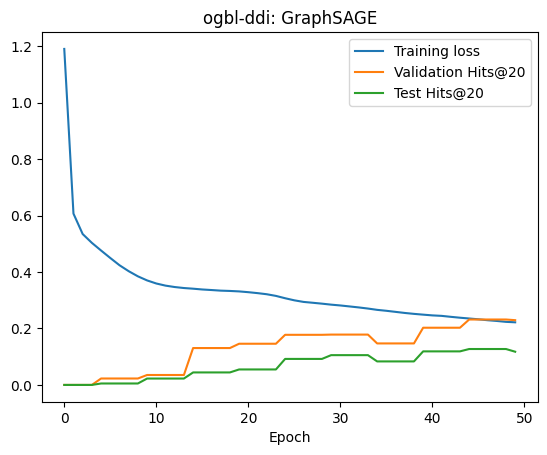

In [ ]:
# now training and evaluation
# using evaluation metrics hits@20

import matplotlib.pyplot as plt
epochs_bar = trange(1, epochs+1, desc='Loss n/a') # trange equals to tqdm(range(...))

edge_index = ddi_graph.edge_index.to(device)
pos_train_edges = train_edges['edge'].to(device)

losses = []
valid_hits_list = []
test_hits_list = []
for epoch in epochs_bar: # model is trained epoch by epoch
    loss = train(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_train_edges, optimizer, batch_size)
    losses.append(loss)

    epochs_bar.set_description(f'Loss {loss:0.4f}')

    if epoch % eval_steps == 0: # if current epoch is a multiple of eval_steps
        valid_hits, test_hits = test(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator)
        print() # print a blank line
        print(f'Epoch: {epoch}, Validation Hits@20: {valid_hits["hits@20"]:0.4f}, Test Hits@20: {test_hits["hits@20"]:0.4f}')
        valid_hits_list.append(valid_hits['hits@20'])
        test_hits_list.append(test_hits['hits@20'])
    else: # if not evaluating then using the last known metric (0 if nothing yet)
        valid_hits_list.append(valid_hits_list[-1] if valid_hits_list else 0)
        test_hits_list.append(test_hits_list[-1] if test_hits_list else 0)

plt.title(dataset.name + ": GraphSAGE")
plt.xlabel("Epoch")
plt.plot(losses, label="Training loss")
plt.plot(valid_hits_list, label="Validation Hits@20")
plt.plot(test_hits_list, label="Test Hits@20")
plt.legend()
plt.show()
